In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone https://github.com/fernandososter/RAG.git

Cloning into 'RAG'...
remote: Enumerating objects: 20520, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 20520 (delta 25), reused 17 (delta 5), pack-reused 20474 (from 2)
Receiving objects: 100% (20520/20520), 229.94 MiB | 20.61 MiB/s, done.
Resolving deltas: 100% (3368/3368), done.


In [4]:
!pip install -r /content/RAG/QLoRA-Youtube/requirements.txt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 14.0 MB/s eta 0:00:00


In [5]:
import os
import pandas as pd
import scipy as sp
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, set_seed
from peft import PeftModel
#from item import Item
import pickle
from google.colab import userdata




ModuleNotFoundError: No module named 'item'

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
  if gpu_info.find('Tesla T4') >= 0:
    print("Success - Connected to a T4")
  else:
    print("NOT CONNECTED TO A T4")

In [ ]:
hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [ ]:
df = pd.read_csv("dataset/youtube_video.csv")
df.head()

,video_id,title,channel_name,channel_id,view_count,like_count,comment_count,published_date,thumbnail
0,QwtOeDR-N3g,Why do Human Feet Wash up on This Beach? | Fas...,Fascinating Horror,UCFXad0mx4WxY1fXdbvtg0CQ,33955,1817,119,2025-10-03T09:15:02Z,https://i.ytimg.com/vi/QwtOeDR-N3g/hqdefault.jpg
1,K0fw1uiSGE0,"Range Rover SV (2025) - The King of the City, ...",CAR TV,UCs_gcVRMHEx5mVXfQ7icQTg,59659,1130,22,2025-10-08T09:10:46Z,https://i.ytimg.com/vi/K0fw1uiSGE0/hqdefault.jpg
2,StuKQpzfyjI,Bruce Wayne Becomes Batman - NEW Gotham City U...,Just4fun290,UCdPG86Ahrf9A8YzBnFDAaEg,8658,89,0,2025-10-04T15:00:06Z,https://i.ytimg.com/vi/StuKQpzfyjI/hqdefault.jpg
3,C91854vbs8I,How the music of Mario Kart has evolved,Thomas Game Docs,UCyy7dZhgfeMMctSoo3wDXlQ,161045,5391,239,2025-05-08T15:32:15Z,https://i.ytimg.com/vi/C91854vbs8I/hqdefault.jpg
4,1DaHVSmx160,My bulldog loves mess... you can see that )))),Enzo English Bulldog,UCkk_2IfQ52OJcCUXOrJBtnw,7620,94,24,2021-08-12T15:33:31Z,https://i.ytimg.com/vi/1DaHVSmx160/hqdefault.jpg


In [ ]:
df.isna().sum()

video_id          0
title             0
channel_name      0
channel_id        0
view_count        0
like_count        0
comment_count     0
published_date    0
thumbnail         0
dtype: int64

((array([-4.44217574, -4.2475061 , -4.14176677, ...,  4.14176677,
          4.2475061 ,  4.44217574]),
  array([         0,          0,          0, ..., 2017112317, 3751827725,
         5367568626])),
 (np.float64(3366103.9360771207),
  np.float64(1301435.267008845),
  np.float64(0.14567608518398442)))

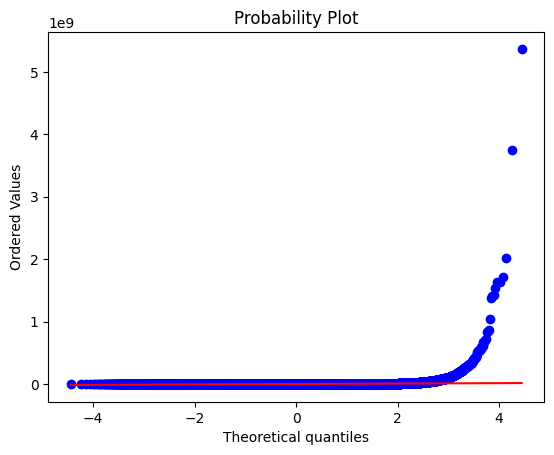

In [ ]:
sp.stats.probplot(df['view_count'], dist="norm", plot=plt)

((array([-4.44217574, -4.2475061 , -4.14176677, ...,  4.14176677,
          4.2475061 ,  4.44217574]),
  array([       0,        0,        0, ..., 11828524, 12092389, 14119478])),
 (np.float64(44628.93027397442),
  np.float64(19958.19542747752),
  np.float64(0.3033628314761188)))

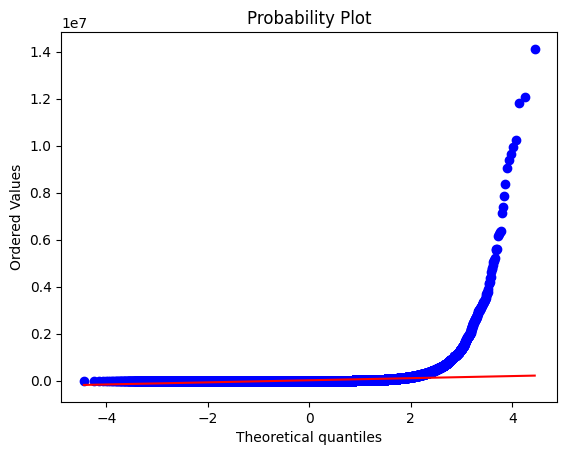

In [ ]:
sp.stats.probplot(df['like_count'], dist="norm", plot=plt)

In [ ]:
BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
PROJECT_NAME = "QLoRA-Youtube"
HF_USER = "fsoster"

QUANT_4_BIT = True

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}
RUN_NAME = "2025-11-11_13.04.39"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"

FINETUNED_MODEL = f"{HF_USER}/{PROJECT_RUN_NAME}"

%matplotlib inline

In [ ]:
pkl_train_file = 'dataset/train.pkl'
pkl_test_file = 'dataset/test.pkl'

if os.path.exists(pkl_train_file):
  with open(pkl_train_file, "rb") as f:
        train = pickle.load(f)

  with open(pkl_test_file, "rb") as f:
        test = pickle.load(f)

else:
    columns = ["title", "view_count"]
    items = [Item(**item) for item in df[columns].to_dict(orient="records")]
    test = items[:round(len(items)*0.3)]
    train = items[round(len(items)*0.3):]
    with open(pkl_train_file, 'wb') as file:
        pickle.dump(train, file)

    with open(pkl_test_file, 'wb') as file:
        pickle.dump(test, file)

In [ ]:
len(train), len(test)

(108968, 46701)

In [ ]:

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [ ]:
set_seed(42)
prompt = train[0].prompt
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:.1f} GB")

ImportError: The installed version of bitsandbytes (<0.43.1) requires CUDA, but CUDA is not available. You may need to install PyTorch with CUDA support or upgrade bitsandbytes to >=0.43.1.

In [ ]:

inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
attention_mask = torch.ones(inputs.shape, device="cuda")
outputs = base_model.generate(inputs, max_new_tokens=4, attention_mask=attention_mask, num_return_sequences=1)
response = tokenizer.decode(outputs[0])

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="cpu",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id


fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)

print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")

In [ ]:
fine_tuned_model